## Loading the dataset
### Imports

In [58]:
from pathlib import Path

import keras.optimizers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

### Useful functions

In [59]:
def filename_to_metadata(file_names: list[str], file_extension: str, only_labels=False):
    """
    Gets dataset type, fold, source name, label and take from .wav filename.

    :param file_names: List of .wav filename strings
    :param file_extension: The file extension (e.g. .wav).
    :param only_labels: Bool, where True means returning only a list of labels.
    :return: Array of dictionaries ["dataset_type", "fold", "source_name", "label", "take"] or strings as Numpy array.
    """
    # stft-1-137-A-32.wav
    # stft --> Dataset type
    # 1 --> Fold
    # 137 --> Source name
    # A --> Take
    # 32 --> Label

    metadata_list = []

    for filename in file_names:
        filename = filename.replace(file_extension, "")
        dataset_type, fold, source_name, take, label = re.split(r"-", filename)

        data_dict = {"dataset_type": dataset_type, "fold": int(fold), "source_name": source_name, "take": take,
                     "label": int(label)}

        if only_labels:
            metadata_list.append(data_dict["label"])
        else:
            metadata_list.append(data_dict)

    return np.array(metadata_list)

In [60]:
def filepath_to_img_data(path_to_dir: Path, filenames: list[str], resize_shape: tuple[int, int]=None):
    """
    Takes the path to images to create data objects.

    :param path_to_dir: Path object of the path to the data directory.
    :param filenames: List of filenames.
    :param resize_shape: The new dimensions of the images.
    :return: Array of image data as Numpy array.
    """
    img_data = []

    class_range = []

    for filename in filenames:
        path_to_img = path_to_dir / filename

        base_img = cv2.imread(str(path_to_img))
        final_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)

        if resize_shape is not None:
            fixed_resize_shape = resize_shape[::-1] # Necessary because CV2 is inconsistent with order of width and height
            final_img = cv2.resize(final_img, fixed_resize_shape)

        img_data.append(final_img)

    return np.array(img_data)

In [61]:
# Generated by Chat
def plot_confusion_matrix(
    y_true,
    y_pred,
    class_names,
    normalize=True,
    cmap="YlOrBr",
    figsize=(12, 10),
    title="Confusion Matrix",
    text_size=6
):
    """
    General confusion matrix plotter with clean styling.
    """

    # Create class names if none provided
    if class_names is None:
        _num_classes = len(np.unique(np.concatenate([y_true, y_pred])))
        class_names = [f"Class {i}" for i in range(_num_classes)]

    cm = confusion_matrix(y_true, y_pred)

    # Normalize
    if normalize:
        with np.errstate(divide="ignore", invalid="ignore"):
            cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        cm_display = np.round(cm, 2)
    else:
        cm_display = cm

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()

    # Ticks
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=text_size)
    plt.yticks(tick_marks, class_names, fontsize=text_size)

    # Add numbers inside tiles (small font for large matrices)
    thresh = np.nanmax(cm) / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm_display[i, j]
            if normalize and (np.isnan(value) or np.isinf(value)):
                text = ""
            else:
                text = value

            plt.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                fontsize=text_size,
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

### Relative paths, generally useful

In [62]:
path_to_data = Path.cwd() / ".." / "data"

path_to_waveform = path_to_data / "waveform"
path_to_stft = path_to_data / "STFT"
path_to_mel = path_to_data / "mel"

### Load images as dataset X and y
* Resizing of image
* Choosing which dataset to use

In [63]:
def dataset_to_use(dataset: str, num_classes_to_use: int=50, image_size: tuple[int, int]=None, train_split_ratio=0.9, rng=42):
    """
    :param dataset: String of which dataset to use, ["wav", "stft", "mel"]
    :param num_classes_to_use: Between 1 and 50, how many classes from 0 to have in the dataset.
    :param image_size: Height x width, to resize the images.
    :param train_split_ratio: The ratio [0, 1] that will make up the train dataset.
    :param rng: Just a random seed for the train_test_split function.
    :return: X_train, X_test, y_train, y_test in that order, of the chosen dataset.
    """
    if dataset == "wav":
        waveform_filenames = [file.name for file in path_to_waveform.glob("*.png")]

        # Create X dataset of images and normalize
        wav_X = filepath_to_img_data(path_to_waveform, waveform_filenames, resize_shape=image_size)
        wav_X = wav_X / 255

        # Create y datasets out of filenames
        wav_y = filename_to_metadata(waveform_filenames, ".png", only_labels=True)

        # Cut the datasets into fewer classes
        if num_classes_to_use != 50:
            idx_included = np.isin(wav_y, np.arange(num_classes_to_use)) # Assume all y datasets are identical
            wav_X = wav_X[idx_included]
            wav_y = wav_y[idx_included]

         # Just in case, make the datasets to Numpy arrays
        wav_X = np.array(wav_X)
        wav_y = np.array(wav_y)

        return train_test_split(wav_X, wav_y, train_size=train_split_ratio, random_state=rng)
    if dataset == "stft":
        stft_filenames = [file.name for file in path_to_stft.glob("*.png")]

        # Create X dataset of images and normalize
        stft_X = filepath_to_img_data(path_to_stft, stft_filenames, resize_shape=image_size)
        stft_X = stft_X / 255

        # Create y datasets out of filenames
        stft_y = filename_to_metadata(stft_filenames, ".png", only_labels=True)

        # Cut the datasets into fewer classes
        if num_classes_to_use != 50:
            idx_included = np.isin(stft_y, np.arange(num_classes_to_use)) # Assume all y datasets are identical
            stft_X = stft_X[idx_included]
            stft_y = stft_y[idx_included]

        # Just in case, make the datasets to Numpy arrays
        stft_X = np.array(stft_X)
        stft_y = np.array(stft_y)

        return train_test_split(stft_X, stft_y, train_size=train_split_ratio, random_state=rng)
    if dataset == "mel":
        mel_filenames = [file.name for file in path_to_mel.glob("*.png")]

        # Create X dataset of images and normalize
        mel_X = filepath_to_img_data(path_to_mel, mel_filenames, resize_shape=image_size)
        mel_X = mel_X / 255

        # Create y datasets out of filenames
        mel_y = filename_to_metadata(mel_filenames, ".png", only_labels=True)

        # Cut the datasets into fewer classes
        if num_classes_to_use != 50:
            idx_included = np.isin(mel_y, np.arange(num_classes_to_use)) # Assume all y datasets are identical
            mel_X = mel_X[idx_included]
            mel_y = mel_y[idx_included]

        # Just in case, make the datasets to Numpy arrays
        mel_X = np.array(mel_X)
        mel_y = np.array(mel_y)

        return train_test_split(mel_X, mel_y, train_size=train_split_ratio, random_state=rng)

    return None

In [64]:
dataset_str = "stft"
image_resize = (512, 512)
num_classes = 10 # Classes to use

X_train, X_test, y_train, y_test = dataset_to_use(dataset_str, num_classes_to_use=num_classes, image_size=image_resize)

# Dataset information
num_train_samples = X_train.shape[0]
img_size = X_train.shape[1:-1]
num_channels = X_train.shape[-1]
# num_classes defined above
input_shape = X_train.shape[1:]

# Class distribution
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print(f"Class distribution (train set): {np.bincount(y_train)}")
print(f"Class distribution (test set): {np.bincount(y_test)}")

# Image- and input shape information
print(f"Image size (height x width): {img_size[0]} x {img_size[1]}")
print(f"Input shape: ({input_shape})")

Train set shape: (360, 512, 512, 3)
Test set shape: (40, 512, 512, 3)
Class distribution (train set): [36 37 39 34 35 37 32 38 37 35]
Class distribution (test set): [4 3 1 6 5 3 8 2 3 5]
Image size (height x width): 512 x 512
Input shape: ((512, 512, 3))


## Defining the CNN model

### Parameters:
* Classes = 50
* Channels = 3
* Kernel size
* Padding
* Stride
* Dilation

### Layers:
* Pooling (max pooling and average pooling)
* Strided conv
* Normalization
* Activation (ReLU)
* Conv --> Normalization --> Activation

### Dense:
* Regular NN

In [65]:
def cnn_model(_input_shape, _num_classes):
    # Parameters
    act_func = "swish"
    k_size = 3
    p_size = (2, 2)  # (Height, width)

    # Model definition
    _model = models.Sequential()
    _model.add(layers.InputLayer(_input_shape))

    # Convolution layers
    ## Convolution 1
    _model.add(layers.Conv2D(filters=32, kernel_size=k_size, activation=act_func, padding="same"))
    _model.add(layers.MaxPooling2D(p_size))

    ## Convolution 2
    _model.add(layers.Conv2D(filters=64, kernel_size=k_size, activation=act_func, padding="same"))
    _model.add(layers.MaxPooling2D(p_size))

    ## Convolution 3
    _model.add(layers.Conv2D(filters=128, kernel_size=k_size, activation=act_func, padding="same"))
    _model.add(layers.MaxPooling2D(p_size))
    #_model.add(layers.Dropout(0.1))

    ## Convolution 4
    _model.add(layers.Conv2D(filters=256, kernel_size=k_size, activation=act_func, padding="same"))
    _model.add(layers.MaxPooling2D(p_size))

    ## Convolution 5
    _model.add(layers.Conv2D(filters=256, kernel_size=k_size, activation=act_func, padding="same"))
    _model.add(layers.MaxPooling2D(p_size))

    # Dense layer
    _model.add(layers.Flatten())
    _model.add(layers.Dense(512, activation=act_func))
    _model.add(layers.Dropout(0.3))
    _model.add(layers.Dense(_num_classes, activation="softmax"))

    # Compile and summary
    _model.compile(
        optimizer="adam",
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    _model.summary()

    return _model

## Training the model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,538,570 (131.75 MB)

 Trainable params: 34,538,570 (131.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.2253 - loss: 2.2732 - val_accuracy: 0.3611 - val_loss: 2.0175
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.2685 - loss: 2.1092 - val_accuracy: 0.1667 - val_loss: 2.2915
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.4167 - loss: 1.7366 - val_accuracy: 0.2222 - val_loss: 2.6526
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.5031 - loss: 1.5000 - val_accuracy: 0.3056 - val_loss: 2.2935
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.5895 - loss: 1.2913 - val_accuracy: 0.4444 - val_loss: 1.6369
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.7006 - loss: 0.8305 - val_accuracy: 0.6389 - val_loss: 1.4412
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7377 - loss: 0.7604 - val_accuracy: 0.6111 - val_loss: 1.5558
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.8302 - loss: 0.4902 - val_accuracy: 0.5278 - val_loss:

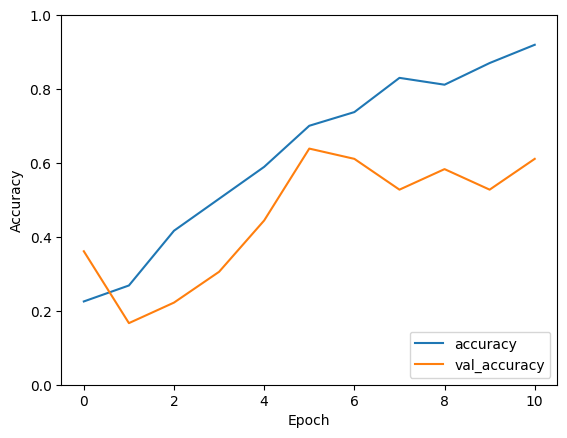

In [66]:
num_epochs = 50
batch_size = 32
validation_split = 0.1

model = cnn_model(_input_shape=input_shape, _num_classes=num_classes)
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_split=validation_split, callbacks=[es_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

## Testing the model

In [67]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Testing accuracy: {test_acc * 100:.1f}%")

2/2 - 2s - 762ms/step - accuracy: 0.7250 - loss: 0.7910
Testing accuracy: 72.5%


## Confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step


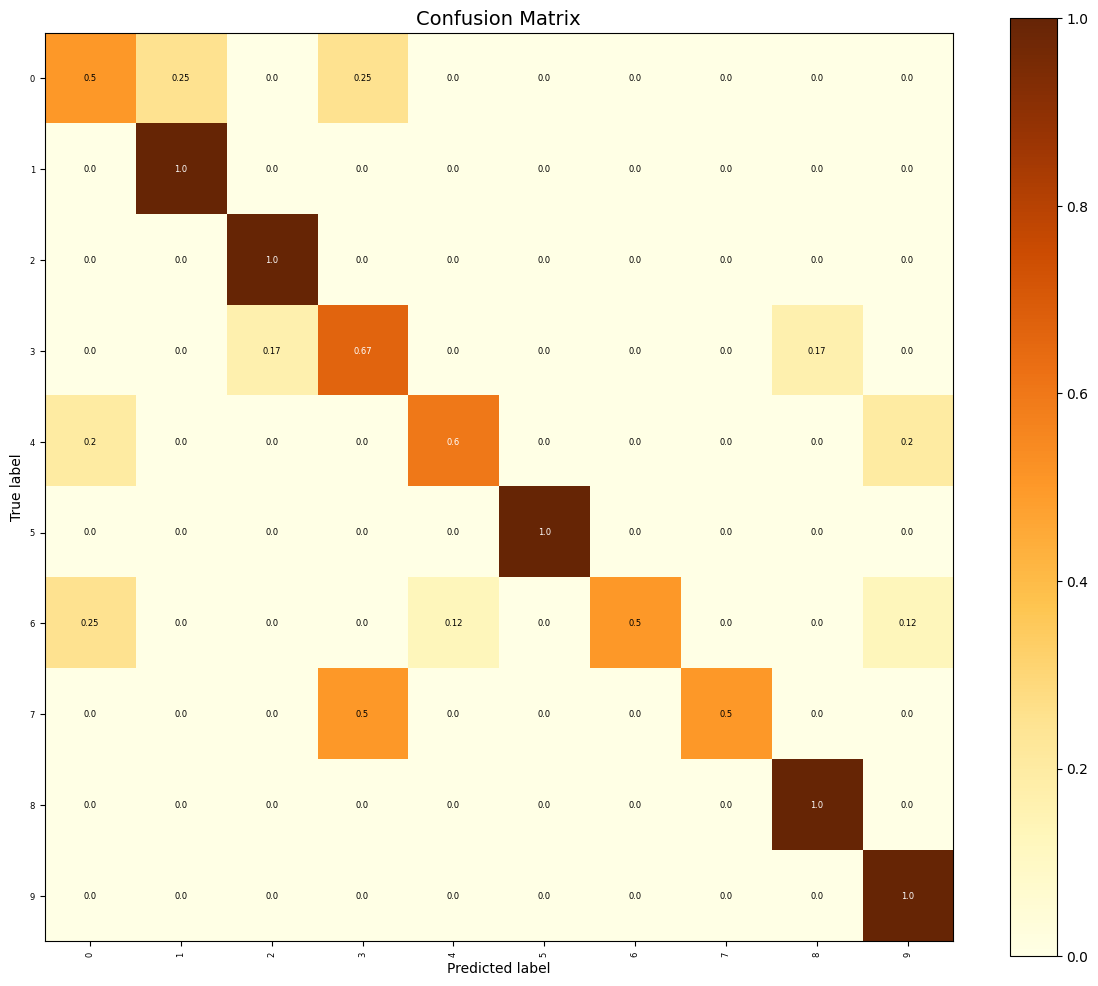

In [68]:
y_test_pred = np.argmax(model.predict(X_test), axis=1)
plot_confusion_matrix(y_test, y_test_pred, np.arange(num_classes))